In [1]:
from read_VA import read_VA
from CA_analysis import read_data
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [23]:
def find_cycles(data, pert_times, threshold_I_multiplier=1, sign_change = 1):
    '''
    Divide the signal into cycles by cutting when the current
    crosses a specific value.

    Parameters
    ----------
    data : pd.DataFrame
        experimental data
    threshold_I_multiplier : float
        point where I == threshold_I is defined
        to have phase = 0; defined as fraction of mean current
    sign_change : int
        1 when I raises at phase==0, otherwise -1

    
    Returns
    -------
    cycles : pd.DataFrame
        A dataframe describing period information
            start -- t at which phase == 0
            duration -- T of this period
    '''
    
    # Calculate current relative to the threshold
    threshold_I = data.mean()['I']*threshold_I_multiplier
    data['I relative'] = data['I']-threshold_I

    # Calculate crossings and create 'cycles' dataframe
    crossings = data[(np.diff(np.sign(data['I relative']), append=0) == 2*sign_change)]
    crossing_times = np.array(crossings['t'])
    period_durations = np.diff(crossing_times)
    voltage = np.array(crossings['U'])


    dt = np.min(np.abs(np.subtract.outer(crossing_times, pert_times)), axis=1)



    unpurged_cycles = pd.DataFrame({'start'     : crossing_times,
                                    'duration'  : np.append(period_durations, np.nan),
                                    'U'         : voltage,
                                    'dt'        : dt})
    
    # Remove false crossings (when period is too short)
    # mean_period = np.mean(unpurged_cycles['duration'])
    # cycles = unpurged_cycles[(unpurged_cycles['duration'] > 40)]

    cycles = unpurged_cycles[(unpurged_cycles['U'] < 4.05)]
    cycles = cycles[(cycles['dt'] > 1)]  
    cycles = cycles.assign(duration= np.diff(cycles['start'], append=np.nan))
    cycles = cycles[(cycles['duration'] > 40) & (cycles['duration'] < 70)] 

    cycles = cycles.drop(cycles.tail(1).index) # Drop last row
    cycles.reset_index(drop=True, inplace=True)
    
    return cycles, threshold_I

In [24]:
def pert_response(cycles, pert_times):
    '''
    Create a dataframe with data about the perturbations.

    Parameters
    ----------
    cycles : pd.DataFrame
        A dataframe describing period information
            start -- t at which phase == 0
            duration -- T of this period
    pert_times : np.ndarray
        An array of values of time when perturbations happened

    Returns
    -------
    perts : pd.DataFrame
        A dataframe describing information about each perturbation
            time -- start of the perturbation
            in_which_period -- index of the cycle in which pert occured
            phase -- osc phase at which pert occured relative to I crossing
            # corrected_phase -- osc phase relative to current maximum
            response -- phase response over current and next period
                as a fraction of a mean period
    period_fit : np.ndarray
        List of coefficients of a 2nd degree polynomial fit to periods vs time.
    '''


    in_which_period = np.searchsorted(cycles['start'], np.array(pert_times))-1
    
    period_fit = np.polyfit(cycles['start'], cycles['duration'], 2)
    expected_period = np.polyval(period_fit, cycles['start'],)
    expected_period = expected_period[list(in_which_period)]
    
    phase = (pert_times-cycles['start'].iloc[in_which_period])/expected_period
    
    
    affected_periods_durations = np.array([cycles['duration'].iloc[x:x+2] for x in in_which_period])
    response = np.sum(affected_periods_durations, axis=1)-2*expected_period
    
    perts = pd.DataFrame({'time'            : pert_times,
                        'in_which_period'   : in_which_period,
                        'phase'             : phase,
                        'response'          : response,
                        'expected_period'   : expected_period})

    return perts, period_fit

In [25]:
def phase_correction(data, perts, cycles, mean_period):
    '''
    Account for different phase determination method by offseting phase
    such that max current means phase = 0.

    Parameters
    ----------
    data : pd.DataFrame
        Experimental data
    perts : pd.DataFrame
        Data on the perturbations
    cycles : pd.DataFrame
        Period data
    mean_period : float
        Mean cycle duration in seconds

    Returns
    -------
    perts : pd.DataFrame
        Updated perts dataframe with a new column: corrected_phase
    correction : float
        Average osc phase of current spikes (calculated with a relative method)
    '''
    spikes, _ = find_peaks(data['I'], height=0.06, distance=1000)
    time_array = np.array(data['t'])
    spike_times = time_array[spikes]
    size = min(spike_times.size, cycles.shape[0])
    correction = np.average(spike_times[:size]-cycles['start'].iloc[:size])%mean_period/mean_period
    print(f'{correction = }')
    # corrected_phase = (perts['phase']+correction)%1
    perts.drop(perts.tail(perts.shape[0]-size).index, inplace=True)
    perts = perts.assign(corrected_phase = perts['phase']) #!DEBUG # corrected_phase)

    return perts, correction

In [5]:
data, pert_times = read_data('T:\\Team\\Szewczyk\\Data\\20240109\\A00502_C01.mpr',
                         roi=(1000, 8999000), p_height=0.3)

c:\Users\go68nim\AppData\Local\Programs\Python\Python312\Lib\site-packages\eclabfiles\mpr.py:711: UserWarning: No log present in file. Data will not contain absolute time.
  warnings.warn("No log present in file. Data will not contain absolute time.")


In [26]:
cycles, threshold_I = find_cycles(data, pert_times)
mean_period = np.mean(cycles['duration'])

# Calculate perturbation response
perts, period_fit = pert_response(cycles, pert_times)
perts, correction = phase_correction(data, perts, cycles, mean_period)

correction = 0.8661403675625712


In [34]:
correction = 0

corrected_phase = (perts['phase']+correction)%1
perts = perts.assign(corrected_phase = corrected_phase)


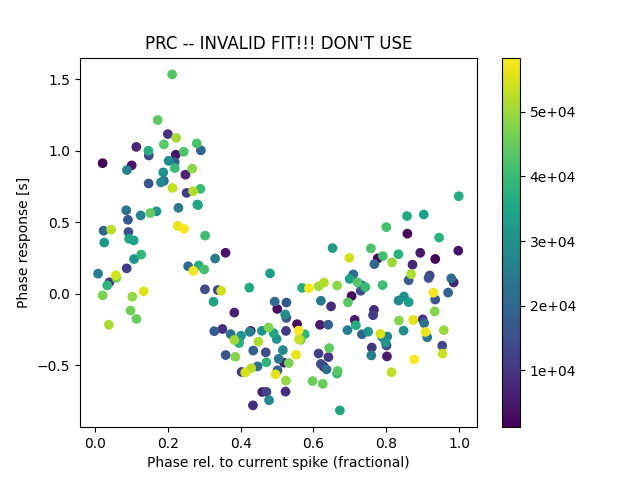

In [35]:
%matplotlib widget

# Plot PRC
plt.figure()
plt.title("PRC -- INVALID FIT!!! DON'T USE")
plt.xlabel('Phase rel. to current spike (fractional)')
plt.ylabel('Phase response [s]')
sc = plt.scatter(perts['corrected_phase'], perts['response'], c=perts['time'])
plt.colorbar(sc, format='%1.0e')

Text(0, 0.5, 'Osc. period [s]')

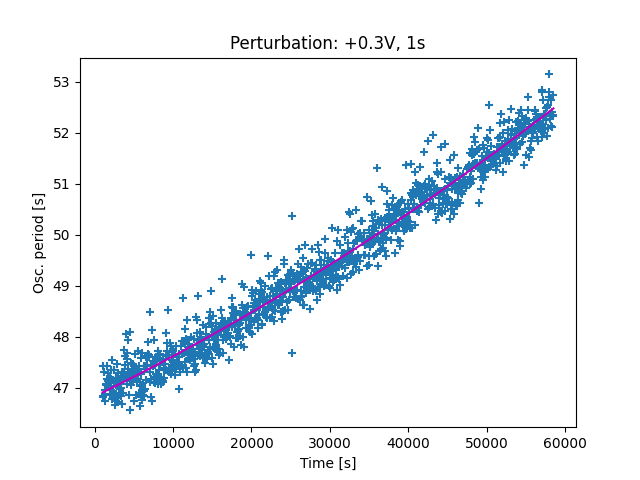

In [29]:
# Plot periods vs time
plt.figure()
plt.title('Period length versus time')
plt.scatter(cycles['start'], cycles['duration'], marker='+')
plt.plot(cycles['start'], np.polyval(period_fit, cycles['start']), 'm-')

# for x in pert_times:
    # plt.axvline(x, c='r', ls='--')
plt.title('Perturbation: +0.3V, 1s')
plt.xlabel('Time [s]')
plt.ylabel('Osc. period [s]')

(2000.0, 2100.0)

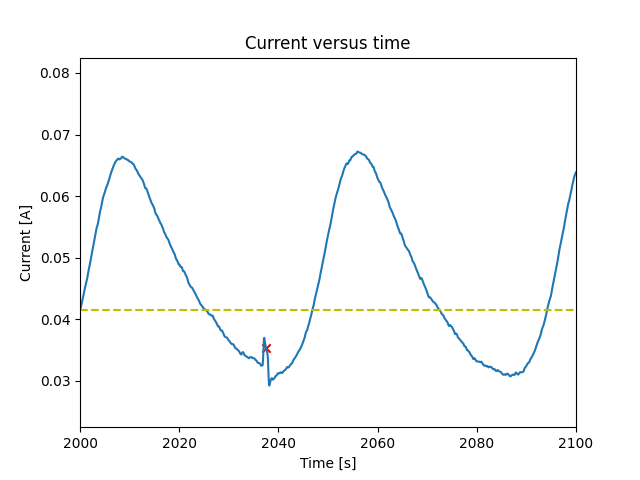

In [19]:
# Plot current vs time
plt.figure()
plt.title('Current versus time')
plt.plot(data['t'], data['I'])
plt.axhline(threshold_I, c='y', ls='dashed')
plt.scatter(pert_times, data[data['t'].isin(pert_times)]['I'], marker='x', c='r')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
# plt.plot(data['t'], data['U'], 'm-')
# for x in cycles['start']:
    # plt.axvline(x, c='g', ls='-.')
plt.xlim(2000, 2100)